In [1]:
import sys
# sys.path is a list of absolute path strings
sys.path.append('./Script')

import data1 as data
import random
from multilabel import *
from common import *
from sklearn.model_selection import cross_validate, KFold
import numpy as np
import matplotlib.colors as mcolorss
import statsmodels.api as sm
from linear_models import *

In [2]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multioutput import ClassifierChain
from multilabel import BinaryRelevanceClassifier, ProbabilisticClassifierChain

STATE = np.random.RandomState(seed=1000)
MAX_ITER = 10000

l1_ratios = [0.5 for _ in data.x1.columns]
lr_sklearn_l1 = LogisticRegressionCV(penalty='l1', solver='saga', random_state=STATE, max_iter=MAX_ITER)
lr_sklearn_l2 = LogisticRegressionCV(penalty='l2', solver='lbfgs', random_state=STATE, max_iter=MAX_ITER)
lr_sklearn_net = LogisticRegressionCV(penalty='elasticnet', solver='saga', random_state=STATE, max_iter=MAX_ITER, \
                                     l1_ratios = l1_ratios)

lr_sklearn_l1 = ProbabilisticClassifierChain(lr_sklearn_l1)
lr_sklearn_l2 = ProbabilisticClassifierChain(lr_sklearn_l2)

# elasticnet
lr_sklearn_net = ProbabilisticClassifierChain(lr_sklearn_net)
glm_net = ProbabilisticClassifierChain(GlmWrapper(max_iter=2*MAX_ITER, L1_wt=0.5, alpha=8))

full_estimators = [lr_sklearn_l1, lr_sklearn_l2, lr_sklearn_net, glm_net]
full_names = ['l1_pcc', 'l2_pcc', 'Sknet_pcc', 'Glmnet_pcc']

In [3]:
from common import Experiment, NegLogLikelihoodEvaluator
from sklearn.model_selection import KFold

print("Current Prediction Order is:", data.y.columns.tolist())
print('Num of predictors:, ', data.x1.shape[1])

interpolation = Experiment(full_estimators, 
                            full_names,
                            KFold(30, shuffle=True, random_state=STATE),
                            data.x1, data.y.replace(-1.0, 0.0),
                            groups=data.comp_ids.array, 
                            evaluators=['accuracy', NegLogLikelihoodEvaluator(base=2)],
                            verbose=True).run()

Current Prediction Order is: ['sphere', 'worm', 'vesicle', 'other']
Num of predictors:,  23
Running experiment with 30 repetitions
******************************


In [4]:
df = interpolation.summary()
df

,mean_train_error,std_train_error,mean_test_error,std_test_error,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
l1_pcc,0.617078,0.011528,0.621491,0.149020,2.899577,0.012349,2.922320,0.350100
l2_pcc,0.556380,0.043451,0.588246,0.146107,2.251545,0.100844,2.359290,0.414337
Sknet_pcc,0.623951,0.014037,0.624912,0.146423,2.898544,0.011547,2.922387,0.352078
Glmnet_pcc,0.672822,0.010615,0.684298,0.117877,2.603225,0.018814,2.660096,0.314455


In [5]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import math

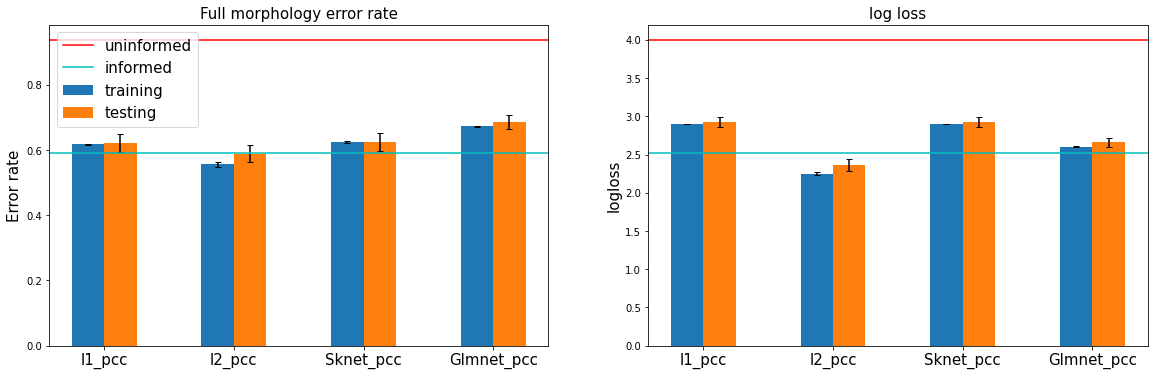

In [6]:
def cm2inch(*tupl):
    """This function is for the actual size (cm) of plots
    Input: 
        tuple: for example (12, 13) means 12cm, 13 cm
    Output:
        tuple: for python figsize
    """
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    
colors = ['r', 'c', 'm', 'y', 'b']
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=True)
fig.set_size_inches(cm2inch(50, 15))

width = 0.25
fontsize = 15
ind = np.arange(len(df))

ax1.bar(ind-width/2, df[f'mean_train_error'], width=width, label='training', 
        yerr=df[f'std_train_error']/30**0.5, capsize=3.0)
ax1.bar(ind+width/2, df[f'mean_test_error'], width=width, label='testing',
        yerr=df[f'std_test_error']/30**0.5, capsize=3.0)

ax1.set_title('Full morphology error rate', fontsize=fontsize)
ax1.set_xticks(ind)
ax1.set_ylabel('Error rate', fontsize=fontsize)
ax1.set_xticklabels(df.index, fontsize=fontsize)

# add base line
uniq, cnts = np.unique(data.y.values, return_counts=True, axis=0)
unreal_inter_full_info_error = 1 - max(cnts)/sum(cnts)
inter_full_uninfo_error = 1 - (1/2)**4

inter_error_base = [inter_full_uninfo_error, unreal_inter_full_info_error]
inter_error_name = ['uninformed', 'informed']
for i in range(len(inter_error_base)):
    ax1.axhline(y=inter_error_base[i], color=colors[i], linestyle='-', label=inter_error_name[i])

ax1.legend(fontsize=fontsize)

ax2.bar(ind-width/2, df[f'mean_train_log loss'], width=width, label='training', 
        yerr=df[f'std_train_log loss']/30**0.5, capsize=3.0)
ax2.bar(ind+width/2, df[f'mean_test_log loss'], width=width, label='interpolation',
        yerr=df[f'std_test_log loss']/30**0.5, capsize=3.0)

# add baseline
uniq, cnt = np.unique(data.y.values, axis=0, return_counts=True)
prob = cnt/sum(cnt)
unreal_inter_full_info_loss = 0
for each in cnt:
    unreal_inter_full_info_loss += -each * math.log2(each/sum(cnt))
unreal_inter_full_info_loss = unreal_inter_full_info_loss/sum(cnt)
inter_full_uninfo_loss=-math.log2(0.5**4)
full_loss_base = [inter_full_uninfo_loss, unreal_inter_full_info_loss]
full_loss_name = ['uninformed', 'informed']
for i in range(len(full_loss_base)):
    ax2.axhline(y=full_loss_base[i], color=colors[i], linestyle='-', label=full_loss_name[i])

ax2.set_title('log loss', fontsize=fontsize)
ax2.set_xticks(ind)
ax2.set_xticklabels(df.index, fontsize=fontsize)
ax2.set_ylabel('logloss', fontsize=fontsize)

plt.savefig('overall_performance.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

```
df['mean_train_error'] = 1- df['mean_train_accuracy']
df['std_train_error'] = df['std_train_accuracy']
df['mean_test_error'] = 1-df['mean_test_accuracy']
df['std_test_error'] = df['std_test_accuracy']

df['mean_train_log loss'] = -df['mean_train_log likelihood']
df['std_train_log loss'] = df['std_train_log likelihood']
df['mean_test_log loss'] = -df['mean_test_log likelihood']
df['std_test_log loss'] = df['std_test_log likelihood']

df = df[['mean_train_error', 'std_train_error', 'mean_test_error', 'std_test_error',
    'mean_train_log loss', 'std_train_log loss', 'mean_test_log loss', 'std_test_log loss']]
```